Was ist Maschinelles Lernen?
===
Maschinelles Lernen hat sich zu einem leistungsstarken Werkzeug entwickelt, das in einer Vielzahl von Aufgaben nützlich ist. Obwohl diese Aufgaben auf den ersten Blick unterschiedlich erscheinen mögen, teilen sie oft gemeinsame Merkmale – und die Mathematik bietet einen idealen Rahmen, um diese zu beschreiben. Skizzieren wir ein allgemeines Problem des maschinellen Lernens:

> Uns interessiert es, eine Funktion $f: X \longrightarrow Y$ zu beschreiben (also zu „lernen“), d.h. $f(x) = y$, und zwar auf erklärende Weise – das bedeutet, wir verfügen über Daten, die wir dafür nutzen wollen.

Das ist nun recht abstrakt, daher betrachten wir im Folgenden einige konkrete Beispiele.

Bildsegmentierung
---
Hier ist das Argument unserer Funktion $f$ ein Bild $x \in \mathbb{R}^{\text{width} \times \text{height} \times \text{channels}}$, und die Ausgabe $y = f(x)$ ist ebenfalls ein Bild $y \in \mathbb{R}^{\text{width} \times \text{height} \times \text{channels}}$, das die verschiedenen Objekte im Bild mit unterschiedlichen Farben segmentiert.

Unten findet sich ein Beispiel für ein vortrainiertes Modell zur Bildsegmentierung. Das Modell und Beispielcode sind öffentlich verfügbar unter:

[https://pytorch.org/hub/pytorch_vision_fcn_resnet101/](https://pytorch.org/hub/pytorch_vision_fcn_resnet101/)

Using cache found in /home/hoeflerm/.cache/torch/hub/pytorch_vision_v0.10.0


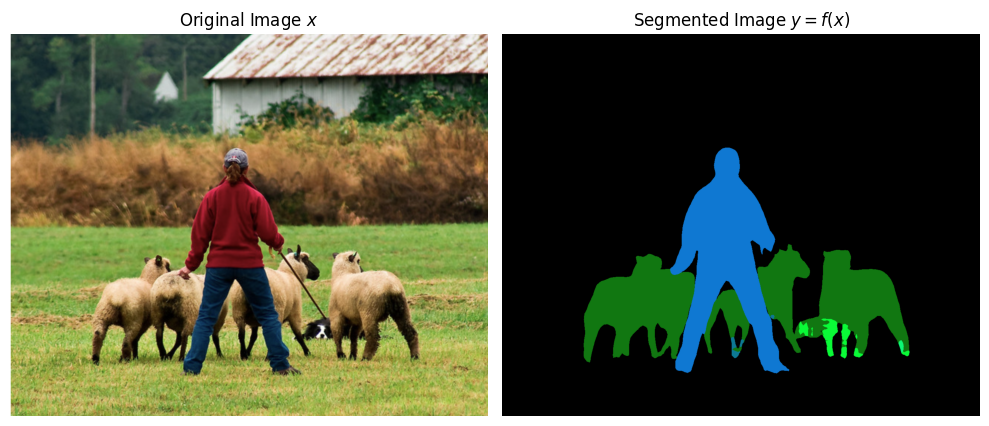

In [3]:
import torch
import urllib
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Download the model
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
model.eval()

# Download an example image to segment
url, filename = ("https://github.com/pytorch/hub/raw/master/images/deeplab1.png", "deeplab1.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# Segment the image
with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

# Display the image
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))  # 2 columns

axes[0].imshow(input_image)
axes[0].set_title('Original Image $x$')
axes[0].axis('off')  # optional

axes[1].imshow(r)
axes[1].set_title('Segmented Image $y=f(x)$')
axes[1].axis('off')  # optional

plt.tight_layout()
plt.show()

Crashkurs zur Bilddarstellung
---
Wir wollen untersuchen, wie ein Bild numerisch dargestellt wird. Grundsätzlich ist ein Bild einfach eine Tabelle, bei der die Zellen einzelne Pixel repräsentieren.

Handelt es sich um ein **Graustufenbild**, speichert jede Zelle einen einzelnen Wert — typischerweise zwischen 0 und 1 oder zwischen 0 und 255 — der angibt, wie „weiß“ der Pixel ist.

Bei einem **RGB-Bild (Rot-Grün-Blau)** speichert jede Zelle **drei Werte**, die den Anteilen von „Rötung“, „Grünung“ und „Bläuung“ entsprechen.

Schauen wir uns das nun etwas genauer an.

The original image $x$ has (1026, 1282) pixels and 3 color channels since it is an RGB image.


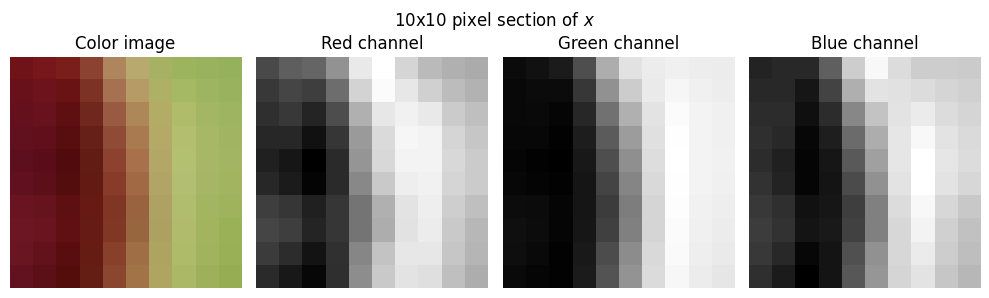

In [49]:
import numpy as np
numpy_image = np.array(input_image.convert('RGB'))

print(f'The original image $x$ has {numpy_image.shape[:2]} pixels and {numpy_image.shape[2]} color channels since it is an RGB image.')

view = numpy_image[550:560,730:740,:]

# Let us display the first 10x10 pixel at the top right corner
fig, axes = plt.subplots(ncols=4, figsize=(10, 3))  # 2 columns

axes[0].imshow(view)
axes[0].set_title('Color image')
axes[0].axis('off')

axes[1].imshow(view[:,:,0], cmap='grey')
axes[1].set_title('Red channel')
axes[1].axis('off')

axes[2].imshow(view[:,:,1], cmap='grey')
axes[2].set_title('Green channel')
axes[2].axis('off')

axes[3].imshow(view[:,:,2], cmap='grey')
axes[3].set_title('Blue channel')
axes[3].axis('off')

fig.suptitle("10x10 pixel section of $x$")
plt.tight_layout()
plt.show()

Bildgenerierung
---
Eine weitere leistungsstarke Anwendung des maschinellen Lernens ist das Erzeugen neuer Bilder. Konzeptionell ist dies etwas anspruchsvoller, daher skizzieren wir hier nur die Grundidee.

Die Funktion $f(x) = y$ erhält weiterhin ein Bild $x \in \mathbb{R}^{\text{width} \times \text{height} \times \text{channels}}$ als Eingabe, aber die Ausgabe ist nun eine **einzelne Zahl** $y \in [0, 1]$, die eine Wahrscheinlichkeit darstellt. Die Idee ist:

- Wenn $x$ ein realistisches Bild ist, dann gilt $f(x) \approx 1$.
- Wenn $x$ nur zufälliges Rauschen ist, dann gilt $f(x) \approx 0$.

Um tatsächlich **neue Bilder zu generieren**, benötigen wir zwei Bausteine:

- Wir lernen unsere Funktion $f$ aus den vorhandenen Daten.
- Wir suchen nach Bildern $x$, sodass $f(x)$ möglichst hoch ist (d.h. nahe bei 1) — das ist ein **Maximierungsproblem**!

Das folgende Modell und ein Beispielcode sind verfügbar unter:

[https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_dcgan/](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_dcgan/)

Using cache found in /home/hoeflerm/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


(-0.5, 529.5, 67.5, -0.5)

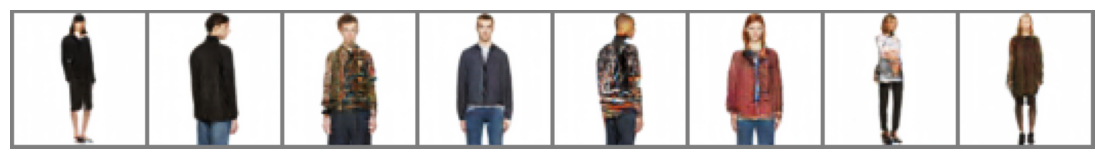

In [64]:
import torch
import matplotlib.pyplot as plt
import torchvision

use_gpu = True if torch.cuda.is_available() else False

model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'DCGAN', pretrained=True, useGPU=use_gpu)

num_images = 8
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

grid = torchvision.utils.make_grid(generated_images).permute(1, 2, 0).cpu().numpy()
grid = (grid - grid.min()) / (grid.max() - grid.min())

fig, ax = plt.subplots(figsize=(14, 8))
ax.imshow(grid)
ax.axis('off')

Bildklassifikation
---
Hier erhält $f(x) = y$ ebenfalls ein Bild $x$ als Eingabe und gibt eine Wahrscheinlichkeit $y \in [0, 1]$ aus. Allerdings zeigt $y$ nun an, ob das Bild zu einer bestimmten Klasse gehört.

Im späteren Beispiel (*cats_and_dogs.ipynb*) wird $y$ verwendet, um anzuzeigen, ob $x$ eine **Katze** oder einen **Hund** zeigt.